In [1]:
%alias nbconvert nbconvert Layout.ipynb

In [2]:
%nbconvert

[NbConvertApp] Converting notebook Layout.ipynb to python


In [3]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

In [4]:
import logging
from pathlib import Path
import copy
from PIL import Image, ImageDraw, ImageFont

In [5]:
try:
    from . import constants
except ImportError as e:
    import constants

try:
    from . import Block as Block
except ImportError as e:
    import Block

In [6]:
class Layout:
    """Class for defining layout of epd screen
    
    This class allows screen layouts to be declared in terms of image blocks within an area. 
    Block placement is defined in terms of absolute or relative positions. Only one block 
    with absolute coordinates is needed. Block size is calculated based on screen size making
    it possible to define one layout that will work on screens of different dimensions.
    
    layouts are specified using the following key/value pairs. Those marked with a * are required
    for all blocks
    *'image': (None/True)          # None/False indicates this will NOT be an image block
    'max_lines': (int)             # maximum number of lines of text this block can accomodate
    'padding': (int)               # number of pixles to add around an image
    *'widht': (int/real)           # fractional portion of screen width this block occupies e.g. 
                                   # 1/2, 1, .25
    *'height': (int/real)          # fractional portion of the screen height this block occupies
    *'abs_coordinates': (tuple)    # tuple of X, Y coordinates where this block lies within the 
                                   # larger screen area. EVERY layout must have at least one block
                                   # that is defined ABSOLUTELY - typically: (0, 0)
                                   # When a block is placed relative to another
                                   # block use `None` to indicate that this is a calculated coordiante
                                   # e.g. (0, None) - Use an absolute value of X=0 and Y=None(calculated)
    'hcenter': (bool)              # horizontally center the text and image of the text in the block
    'vcenter': (bool)              # vertically center the text within the image block
    'rand' (bool)                  # True: randomply place the image within the area (overrides v/h center)
    *'relative': (False/list)      # False for blocks with absolute position; use a list other blocks
                                   # to use for calculating the position of this block e.g.
                                   # ['coverart', title] - reference the block `coverart` for the 
                                   # X position and `title` for the Y position of this block
    'font': (str):                 # Path to font file (relative paths are acceptable)
    'font_size': (None/int)        # None - calculate the font size, int - size in points
    'inverse': (bool)              # True: use black background, white fill

    
    Layouts are defined using any name and can be updated by calling the update() method with 
    a parameter that includes a dictionary containing a key/value pair that matches the names
    see the example below.
    Sample Laout:
    myLayout = {
        'title': {                       # text only block
            'image': None,               # do not expect an image
            'max_lines': 2,              # number of lines of text
            'width': 1,                  # 1/1 of the width - this stretches the entire width of the display
            'height': 2/3,               # 1/3 of the entire height
            'abs_coordinates': (0, 0),   # this block is the key block that all other blocks will be defined in terms of
            'hcenter': True,             # horizontally center text
            'vcenter': True,             # vertically center text 
            'relative': False,           # this block is not relative to any other. It has an ABSOLUTE position (0, 0)
            'font': './fonts/Anton/Anton-Regular.ttf', # path to font file
            'font_size': None            # Calculate the font size because none was provided
        }
    
        'artist' {
            'image': None,
            'max_lines': 1,
            'width': 1,
            'height', 1/3,
            'abs_coordinates': (0, None)   # X = 0, Y will be calculated
            'hcenter': True,
            'vcenter': True,
            'relative': ['artist', title], # use the X postion from abs_coord from `artist` (this block: 0)
                                           # calculate the y position based on the size of `title` block
            
        }
    }
    
    
    Example creating and updating a layout:
    layouts.threeRow has the sections: 'title', 'album', 'artist', 'mode', 'coverart'
    # creates the object and calculates the positions based on the rules set 
    # in the layouts file and screen size
    l = Layout(resolution=(600, 448), layout=myLayout)
    # update/add content to the layout object, applying formatting from layout file
    l.update_contents({'title': 'Hannah Hunt', 'album': 'Modern Vampires of the City', 
                       'artist': 'Vampire Weekend')
                       
    Example displaying layout:
    """
       
    def __init__(self, resolution=(600, 448), layout=None, font=None):
        """  Initializes layout object
        
        Args:
            resolution (:obj:`tuple` of :obj: `int`): X, Y screen resolution in pixles
            layout: (dict): layout
            font (str): path to default font file if none is provided in layout
        Attributes:
            blocks (:obj:`dict` of :obj:`Block`): dictionary of ImageBlock and TextBlock objects"""
        logging.info('Layout created')
        self.resolution = resolution
        if font:
            logging.debug(f'default font specified: {font}')
            self.font = str(Path(font).resolve())
        else:
            logging.debug('no default font specified')
            self.font = None
        self.layout = copy.deepcopy(layout)
        self.images = None #FIXME not needed?

    def _check_keys(self, dictionary={}, values={}):
        """Check `dictionary` for missing key/value pairs specified in `values`
        
        Args:
            dictionary(dict): dictionary to check
            values(dict): dictionary of default key and value pairs
            
        Returns:
            dictionary(dict): dictionary with missing key/value pairs updated"""
            
        logging.debug('checking key/values')
        for k, v in values.items():
            try:
                dictionary[k]
            except KeyError as e:
                logging.debug(f'missing key: {k}; adding and setting to {v}')
                dictionary[k] = v
        return dictionary
    
    def _scalefont(self, font=None, lines=1, text="W ", maxchar=6, dimensions=(100, 100)):
        """Scale a font to fit the number of `lines` within `dimensions`
        
        Args:
            font(str): path to true type font
            text(str): string to use when calculating (default: 'W ')
            maxchar(int): number of characters of `text` to use when calculating 
                default is 'W W W ' -- W is a large character and spaces allow 
                textwrap to work properly
            lines(int): number of lines of text to fit within the `dimensions`
            dimensions(:obj:`tuple` of :obj:`int`): dimensions of pixles
            
        Returns:
            :obj:int: font size as integer"""
            
        if not maxchar:
            maxchar = 6
            logging.debug(f'no max char set; using: {maxchar}')
            
        if font:
            font = str(Path(font).resolve())
        else:
            font = str(Path(self.font).resolve())
        
        if len(text) < maxchar:
            multiplyer = round(maxchar/len(text))
            text = text * multiplyer
        else:
            text = text[0:maxchar] 
    
        
        
        logging.debug('calculating font size')
        logging.debug(f'using text: {text}; maxchar: {maxchar}')
        logging.debug(f'using font at path: {font}')
        
        
        # start calculating at size 1
        fontsize = 1
        x_fraction = .85        
        y_fraction = .7
        xtarget = dimensions[0]*x_fraction
        ytarget = dimensions[1]/lines*y_fraction
        testfont = ImageFont.truetype(font, fontsize)
        fontdim = testfont.getsize(text)
        
        logging.debug(f'target X font dimension {xtarget}')
        logging.debug(f'target Y dimension: {ytarget}')
        
        # loop control variable
        cont = True
        # work up until font covers img_fraction of the resolution return one smaller than this as the fontsize
        while cont:
            fontsize += 1
            testfont = ImageFont.truetype(font, fontsize)
            
            fontdim = testfont.getsize(text)
            if fontdim[0] > xtarget:
                cont = False
                logging.debug(f'X target exceeded')
                
            if fontdim[1] > ytarget:
                cont = False
                logging.debug('Y target exceeded')
            
        # back off one 
        fontsize -= 1
        logging.debug(f'test string: {text}; dimensions for fontsize {fontsize}: {fontdim}')
        return fontsize
    
    @property
    def layout(self):
        ''':obj:dict: dictonary of layout properties and rules for formatting text and image blocks
        
        Sets:
            blocks (dict): dict of ImageBlock or TextBlock objects 
        '''
        return self._layout
    
    @layout.setter
    def layout(self, layout):
        logging.debug(f'calculating values from layout for resolution {self.resolution}')
        if not layout:
            logging.info('no layout provided')
            self._layout = None
        else:
            self._layout = self._calculate_layout(layout)
            if self._layout:
                self._set_images()
            else:
                logging.debug('no layout provided')
    
    
    def _calculate_layout(self, layout):
        """Calculate the size and position of each text block based on rules in layout
        
        Args:
            layout(dict): dictionary containing the layout to be used
        
        Returns:
            layout(dict): dictionary that includes rules and values for the layout"""
        if not layout:
            return None
        l = layout
        
        resolution = self.resolution
        
        # required values that will be used in calculating the layout
        values = {'image': None, 'max_lines': 1, 'padding': 0, 'width': 1, 'height': 1, 
                  'abs_coordinates': (None, None), 'hcenter': False, 'vcenter': False, 
                  'rand': False, 'inverse': False, 'relative': False, 'font': self.font, 
                  'font_size': None, 'maxchar': None, 'dimensions': None}        
        for section in l:
            logging.debug(f'***{section}***')
            this_section = self._check_keys(l[section], values)
                    
            dimensions = (round(resolution[0]*this_section['width']), 
                          round(resolution[1]*this_section['height']))
            
            this_section['dimensions'] = dimensions
            logging.debug(f'dimensions: {dimensions}')       
        
            # set the thumbnail_size to resize the image
            if this_section['image']:
                maxsize = min(this_section['dimensions'])-this_section['padding']*2
                this_section['thumbnail_size'] = (maxsize, maxsize)
            
            # calculate the relative position if needed
            # if either of the coordinates are set as "None" - attempt to calculate the position
            if this_section['abs_coordinates'][0] is None or this_section['abs_coordinates'][1] is None:
                logging.debug(f'has calculated position')
                # store coordinates
                pos = []
                # check each value in relative section
                for idx, r in enumerate(this_section['relative']):
                    if r == section:
                        # use the value from this_section
                        pos.append(this_section['abs_coordinates'][idx])
                    else:
                        # use the value from another section
                        try:
                            pos.append(l[r]['dimensions'][idx] + l[r]['abs_coordinates'][idx])
                        except KeyError as e:
                            m = f'bad relative section value: "{r}" in section "{section}"'
                            raise KeyError(m)
                
                # save the values as a tuple
                this_section['abs_coordinates']=(pos[0], pos[1])
            else:
                logging.debug('has explict position')
                ac= this_section['abs_coordinates']
            logging.debug(f'abs_coordinates: {ac}')
                          
            # calculate fontsize
            if this_section['max_lines']:
                if not this_section['font']:
                    this_section['font'] = self.font
                          
                if not this_section['font_size']:
                    this_section['font_size'] = self._scalefont(font=this_section['font'], 
                                                               dimensions=this_section['dimensions'],
                                                               lines=this_section['max_lines'],
                                                               maxchar=this_section['maxchar'])    

            l[section] = this_section    
        return l
                              
    def _set_images(self):
        """create dictonary of all image blocks with using the current set layout
        
         Sets:
            blocks (dict): dictionary of :obj:`TextBlock`, :obj:`ImageBlock`"""
                          
        layout = self.layout
        
        blocks = {}
        for sec in layout:
            logging.debug(f'***{sec}***)')
            section = layout[sec]
            # any section with max lines accepts text
            if not section['image']: # ['max_lines']:
                logging.debug('set text block')
                blocks[sec] = Block.TextBlock(area=section['dimensions'], 
                                              text='.', 
                                              font=section['font'], 
                                              font_size=section['font_size'], 
                                              max_lines=section['max_lines'], 
                                              maxchar=section['maxchar'],
                                              hcenter=section['hcenter'], 
                                              vcenter=section['vcenter'], 
                                              inverse=section['inverse'], 
                                              rand=section['rand'], 
                                              abs_coordinates=section['abs_coordinates'])
            if section['image']:
                logging.debug('set image block')
                blocks[sec] = Block.ImageBlock(image=None, abs_coordinates=section['abs_coordinates'], 
                                         area=section['dimensions'], hcenter=section['hcenter'],
                                         inverse=section['inverse'], 
                                         vcenter=section['vcenter'], padding=section['padding'])
        self.blocks = blocks
                              
    def update_contents(self, updates=None):
        """Update the contents of the layout
        
        Args:
            updates(dict): dictionary of keys and values that match keys in `blocks`
        
        Sets:
            blocks """
        logging.info('updating blocks')
        if not updates:
            logging.debug('nothing to do')
        
        for key, val in updates.items():
            if key in self.blocks:
                logging.debug(f'updating block: {key}')
                self.blocks[key].update(val)
            else:
                logging.debug(f'ignoring block {key}')

In [36]:
import layouts
from . import Screen
import waveshare_epd

In [37]:
waveshare_epd.epd5in83.EPD_HEIGHT

448

In [32]:
s = Screen.Screen()

INFO:root:Screen created


In [35]:
s.epd = waveshare_epd.epd5in83

In [60]:
lsplash = Layout(resolution=(s.epd.EPD_WIDTH, s.epd.EPD_HEIGHT), layout=layouts.splash)

INFO:root:Layout created
DEBUG:root:no default font specified
DEBUG:root:calculating values from layout for resolution (600, 448)
DEBUG:root:***app_name***
DEBUG:root:checking key/values
DEBUG:root:missing key: maxchar; adding and setting to None
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (600, 269)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (0, 0)
DEBUG:root:no max char set; using: 6
DEBUG:root:calculating font size
DEBUG:root:using text: W W W ; maxchar: 6
DEBUG:root:using font at path: /home/pi/src/slimpi_epd/fonts/Anton/Anton-Regular.ttf
DEBUG:root:target X font dimension 510.0
DEBUG:root:target Y dimension: 188.29999999999998
DEBUG:root:Y target exceeded
DEBUG:root:test string: W W W ; dimensions for fontsize 165: (471, 189)
DEBUG:root:***version***
DEBUG:root:checking key/values
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (600, 45)
DEBUG:root:has calculated position
DEBUG:root:ab

In [74]:
splashu = {'version': ' ', 'url': 'https://github.com/txoof/slimpi_epd', 'app_name': 'SlimPi'}
lsplash.update_contents(splashu)

INFO:root:updating blocks
DEBUG:root:updating block: version
DEBUG:root:formatted list:
 []
DEBUG:root:creating blank image area: (600, 45) with inverse: False
DEBUG:root:dimensions of text portion of image: (0, 0)
DEBUG:root:pasting text portion at coordinates: 300, 22
DEBUG:root:updating block: url
DEBUG:root:formatted list:
 ['https://github.com/txoof/slimpi_epd']
DEBUG:root:creating blank image area: (600, 134) with inverse: False
DEBUG:root:line size: 405, 34
DEBUG:root:max x dim so far: 405
DEBUG:root:dimensions of text portion of image: (405, 34)
DEBUG:root:hcenter line: https://github.com/txoof/slimpi_epd
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 405, 34
DEBUG:root:pasting text portion at coordinates: 98, 50
DEBUG:root:updating block: app_name
DEBUG:root:formatted list:
 ['SlimPi']
DEBUG:root:creating blank image area: (600, 269) with inverse: False
DEBUG:root:line size: 400, 189
DEBUG:root:max x dim so far: 400
DEBUG:root:dimensions of text portion of image: 

In [67]:
lplaying =  Layout(resolution=(s.epd.EPD_WIDTH, s.epd.EPD_HEIGHT), layout=layouts.threeRow)

INFO:root:Layout created
DEBUG:root:no default font specified
DEBUG:root:calculating values from layout for resolution (600, 448)
DEBUG:root:***title***
DEBUG:root:checking key/values
DEBUG:root:missing key: rand; adding and setting to False
DEBUG:root:missing key: inverse; adding and setting to False
DEBUG:root:missing key: maxchar; adding and setting to None
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (600, 256)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (0, 0)
DEBUG:root:no max char set; using: 6
DEBUG:root:calculating font size
DEBUG:root:using text: W W W ; maxchar: 6
DEBUG:root:using font at path: /home/pi/src/slimpi_epd/fonts/Anton/Anton-Regular.ttf
DEBUG:root:target X font dimension 510.0
DEBUG:root:target Y dimension: 89.6
DEBUG:root:Y target exceeded
DEBUG:root:test string: W W W ; dimensions for fontsize 78: (222, 90)
DEBUG:root:***coverart***
DEBUG:root:checking key/values
DEBUG:root:missing key: rand; adding and se

In [71]:
playingu = {'title': 'Down on the Corner', 'coverart': '/tmp/com.txoof.slimpi/5109.jpg', 
            'artist': 'Creedence Clearwater Revival', 
            'album': 'Willy and the Poor Boys', 
            'mode': 'play'}
lplaying.update_contents(playingu)

INFO:root:updating blocks
DEBUG:root:updating block: title
DEBUG:root:formatted list:
 ['Down on the', 'Corner']
DEBUG:root:creating blank image area: (600, 256) with inverse: False
DEBUG:root:line size: 385, 90
DEBUG:root:max x dim so far: 385
DEBUG:root:line size: 207, 89
DEBUG:root:dimensions of text portion of image: (385, 179)
DEBUG:root:hcenter line: Down on the
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 385, 90
DEBUG:root:hcenter line: Corner
DEBUG:root:drawing text at 89, 90
DEBUG:root:with dimensions: 207, 89
DEBUG:root:pasting text portion at coordinates: 108, 38
DEBUG:root:updating block: coverart
DEBUG:root:setting usable image area to: (188, 188) with padding 2
DEBUG:root:using image file: /tmp/com.txoof.slimpi/5109.jpg
DEBUG:root:dimensions: (186, 188)
DEBUG:root:area: (240, 192)
DEBUG:root:h centering image
DEBUG:root:v centering
DEBUG:root:pasting image into area at: 27, 2
DEBUG:root:updating block: artist
DEBUG:root:formatted list:
 ['Creedence Clearwa

In [91]:
lclock = Layout(resolution=(s.epd.EPD_WIDTH, s.epd.EPD_HEIGHT), layout=layouts.clock)

INFO:root:Layout created
DEBUG:root:no default font specified
DEBUG:root:calculating values from layout for resolution (600, 448)
DEBUG:root:***time***
DEBUG:root:checking key/values
DEBUG:root:missing key: maxchar; adding and setting to None
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (600, 392)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (0, 0)
DEBUG:root:no max char set; using: 6
DEBUG:root:calculating font size
DEBUG:root:using text: W W W ; maxchar: 6
DEBUG:root:using font at path: /home/pi/src/slimpi_epd/fonts/Anton/Anton-Regular.ttf
DEBUG:root:target X font dimension 510.0
DEBUG:root:target Y dimension: 274.4
DEBUG:root:X target exceeded
DEBUG:root:test string: W W W ; dimensions for fontsize 180: (513, 206)
DEBUG:root:***mode***
DEBUG:root:checking key/values
DEBUG:root:missing key: maxchar; adding and setting to None
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (600, 56)
DEBUG:ro

In [96]:
lclock.update_contents(clock.get_time())

INFO:root:updating blocks
DEBUG:root:updating block: time
DEBUG:root:formatted list:
 ['14:32']
DEBUG:root:creating blank image area: (600, 392) with inverse: True
DEBUG:root:line size: 371, 206
DEBUG:root:max x dim so far: 371
DEBUG:root:dimensions of text portion of image: (371, 206)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 371, 206
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 188, 141
DEBUG:root:updating block: mode


In [84]:
lwordclock =  Layout(resolution=(s.epd.EPD_WIDTH, s.epd.EPD_HEIGHT), layout=layouts.wordclock)

INFO:root:Layout created
DEBUG:root:no default font specified
DEBUG:root:calculating values from layout for resolution (600, 448)
DEBUG:root:***wordtime***
DEBUG:root:checking key/values
DEBUG:root:missing key: maxchar; adding and setting to None
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (600, 384)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (0, 0)
DEBUG:root:no max char set; using: 6
DEBUG:root:calculating font size
DEBUG:root:using text: W W W ; maxchar: 6
DEBUG:root:using font at path: /home/pi/src/slimpi_epd/fonts/Anton/Anton-Regular.ttf
DEBUG:root:target X font dimension 510.0
DEBUG:root:target Y dimension: 89.6
DEBUG:root:Y target exceeded
DEBUG:root:test string: W W W ; dimensions for fontsize 78: (222, 90)
DEBUG:root:***time***
DEBUG:root:checking key/values
DEBUG:root:missing key: hcenter; adding and setting to False
DEBUG:root:missing key: maxchar; adding and setting to None
DEBUG:root:missing key: dimensions; adding

In [93]:
lwordclock.update_contents(wordclock.get_time())

DEBUG:root:using 14:31
INFO:root:updating blocks
DEBUG:root:updating block: wordtime
DEBUG:root:formatted list:
 ['It is almost', 'Thirty Past Two']
DEBUG:root:creating blank image area: (600, 384) with inverse: True
DEBUG:root:line size: 350, 90
DEBUG:root:max x dim so far: 350
DEBUG:root:line size: 472, 98
DEBUG:root:max x dim so far: 472
DEBUG:root:dimensions of text portion of image: (472, 188)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 350, 90
DEBUG:root:drawing text at 0, 90
DEBUG:root:with dimensions: 472, 98
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 37, 78
DEBUG:root:updating block: time
DEBUG:root:formatted list:
 ['14:31']
DEBUG:root:creating blank image area: (300, 64) with inverse: True
DEBUG:root:line size: 73, 44
DEBUG:root:max x dim so far: 73
DEBUG:root:dimensions of text portion of image: (73, 44)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 73, 44
DEBUG:root:randomly positioning tex

In [97]:
s.elements = lclock.blocks.values()

In [94]:
s.elements = lwordclock.blocks.values()

In [75]:
s.elements = lsplash.blocks.values()

In [72]:
s.elements = lplaying.blocks.values()

DEBUG:root:pasting image at: (0, 0)
DEBUG:root:pasting image at: (0, 392)


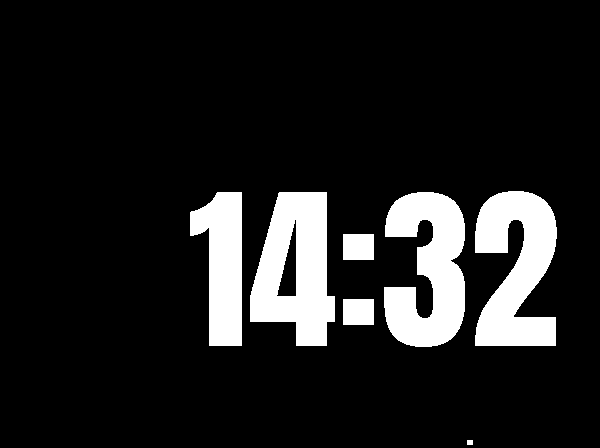

In [99]:
s.concat()

In [81]:
import wordclock
import clock

In [78]:
wordclock

<module 'wordclock' from '/home/pi/src/slimpi_epd/epdlib/wordclock.py'>

In [80]:
wordclock.get_time()

DEBUG:root:using 14:27


{'wordtime': 'It is about Half Past Two', 'time': '14:27', 'mode': None}

In [92]:
clock.get_time()

{'time': '14:31', 'mode': None}